In [ ]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train = x_train.reshape(num_train, -1)    # vectorization
x_test = x_test.reshape(num_test, -1)

# from sklearn.preprocessing import StandardScaler        
# scaler = StandardScaler()
# norm = np.linalg.norm(x_train)
x_train = (x_train) / 255  # normalization to the range [0, 1] 
x_test = (x_test) / 255

In [ ]:

import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


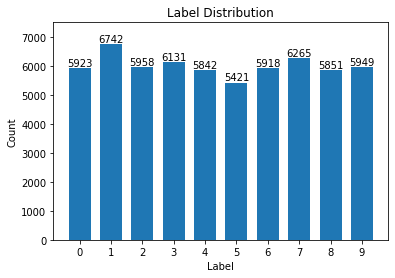

In [ ]:
fig = plt.figure()
plt.bar(label, count, width = 0.7, align='center')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(label)
plt.ylim(0,7500)

for a,b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()

## Activation Functions

In [ ]:
def relu():
    return Relu()


def sigmoid():
    return Sigmoid()


def tanh():
    return Tanh()


def softmax(x):     # softmax
    nx = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(nx)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


def cross_entropy_loss(y_pred, y_true):     # cross entropy as the loss function
    batch = y_true.shape[0]
    return -np.sum(np.log(y_pred[:, y_true] + 1e-7)) / batch


In [ ]:
class Relu:     # relu activation function

    def forward(self, x):
        self.x = x
        self.mask = x <= 0

        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, d): #take derevative for the backward process
        d[self.mask] = 0
        return d


In [ ]:
class Sigmoid:      # sigmoid activation function


    def forward(self, x):
        self.x = x
        self.y = 1.0/(1 + np.exp(-x))
        return self.y

    def backward(self, d): #take derevative for the backward process
        return d * (1.0 - self.y) * self.y


class Tanh:     # tanh activation function

    def forward(self, x):
        self.x = x
        return np.tanh(x)

    def backward(self, d): #take derevative for the backward process
        return d * (1-np.tanh(self.x) ** 2)


In [ ]:
class Affine:       # model x*w + b & error backprop

    def __init__(self, w, b):
        self.w = w
        self.b = b

    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.w) + self.b
        return self.y

    def backward(self, d):
        dx = np.dot(d, self.w.T)
        self.dw = np.dot(self.x.T, d)
        self.db = np.sum(d, axis=0)
        return dx


class SoftmaxLoss:

    def __init__(self):
        pass

    def forward(self, x, y_true):
        self.y_true = y_true
        self.y_pred = softmax(x)
        self.loss = cross_entropy_loss(self.y_pred, self.y_true)
        return self.loss

    def backward(self):
        class_num = self.y_pred.shape[1]
        batch = self.y_true.shape[0]
        y_true_one_hot = np.zeros((batch, class_num))
        y_true_one_hot[np.arange(batch), self.y_true] = 1
        return (self.y_pred - y_true_one_hot) / batch


## MLP

In [ ]:
class MLP:

    def __init__(self, input_layer=784, hidden_layer= [], output_layer=10, max_episode=100000,
                 active_func=relu, batch_size=200, learing_rate=0.1, lamdba=0.5): # intotal 784 pixel inputs, 10 outputs refers to integer 0-9; lamdba for L2
        size = input_layer
        self.layers = []
        self.cal_layer = []

        for hidden in hidden_layer:
            w, b = np.random.randn(size, hidden), np.random.randn(1, hidden)        # w, b refer to "weight" and "bias"
            self.layers.append({'w': w, 'b': b})
            self.cal_layer.append(Affine(w, b))
            self.cal_layer.append(active_func())
            size = hidden

        w, b = np.random.randn(size, output_layer), np.random.randn(1, output_layer)
        self.cal_layer.append(Affine(w, b))
        self.layers.append({'w': w, 'b': b})
        self.active_func = active_func
        # self.de_active_func = active_func[1]
        self.max_episode = max_episode
        self.batch_size = batch_size
        self.lr = learing_rate
        self.lamdba = lamdba #L2

        self.out_layer = SoftmaxLoss()

    def fit(self, X, y):
        for ep in range(self.max_episode):      # number of gradient descent
            # random select some data
            batch = np.random.choice(X.shape[0], self.batch_size)       # sample a part of data each time for implementing mini-batch
            x, y_true = X[batch], y[batch]

             # forward               
            for cal in self.cal_layer:
                x = cal.forward(x)
          

            wd = 0
            for layer in self.layers:
              wd += 0.5 * self.lamdba * np.sum(layer['w'] ** 2) #formula of L2 

            self.out_layer.forward(x, y_true) + wd #return corss-entropy loss + l2

            # backward              # backprop, calculate gradient each iteration
            d = self.out_layer.backward()
            for cal in reversed(self.cal_layer):
                d = cal.backward(d)

            # check grad
            grad = []
            for cal in self.cal_layer:
                if isinstance(cal, Affine):     # only Affine has parameters needed to be updated
                    grad.append({'w': cal.dw, 'b': cal.db})

            # update grad
            for i in range(len(self.layers)):       # update parameter at each iteration -> SGD
                #self.layers[i]['w'] -= self.lr * grad[i]['w'] 
                self.layers[i]['w'] -= self.lr * (grad[i]['w'] + self.lamdba * self.layers[i]['w']) #Grad update when consider L2 
                self.layers[i]['b'] -= self.lr * grad[i]['b']

            

    def predict(self, X):
        x = X
        # for i in range(len(self.layers) - 1):
        #     w, b = self.layers[i]['w'], self.layers[i]['b']
        #     x = self.active_func(np.dot(x, w) + b)

        # w, b = self.layers[len(self.layers) - 1]['w'], self.layers[len(self.layers) - 1]['b']
        # x = np.dot(x, w) + b
        # y = np.argmax(x, axis=1)
        # return y

        for cal in self.cal_layer:
            x = cal.forward(x)
        # self.out_layer.forward(x, y_true)

        x = softmax(x)
        y = np.argmax(x, axis=1)
        return y


    def evaluate(self, y_true, y_predict):
        return sum(y_true == y_predict) / len(y_true)

## Parameter Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
parameters = {
    #"hidden_layer": [[], [128], [128, 128]],
    "hidden_layer": [[]],
    "max_episode": [100000],
    "batch_size": [200],
    "learing_rate": [0.1, 0.01, 0.05, 0.001],
    "lamdba": [0, 0.5, 0.7, 0.9]
}

# Grid Search

from  copy import deepcopy
def generate_all():
    keys = list(parameters.keys())
    parameters_list = [{}]

    for key in keys:
        tmp = []
        for val in parameters[key]:
            for pre in parameters_list:
                pre = deepcopy(pre)
                pre[key] = val
                tmp.append(pre)
        parameters_list = tmp
    return parameters_list

best, best_p, best_acc = None, None, 0

for p in generate_all():
    mlp = MLP(**p)
    mlp.fit(x_train, y_train)
    acc = mlp.evaluate(y_test, mlp.predict(x_test))
    if acc > best_acc:
        best_acc = acc
        best_p = p
        best = mlp
    print("Acc ", acc, " with parameter: ", p)

print("Best acc: ", best_acc)
print("Best mlp parameters: ", best_p)

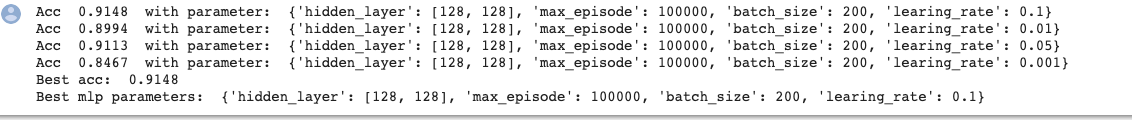

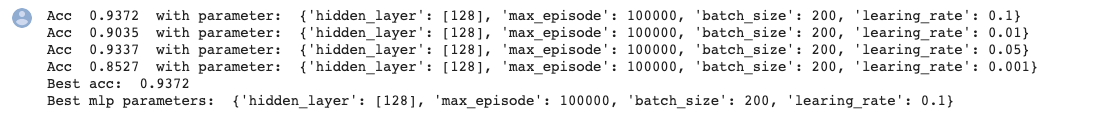

## Run Experiments

In [ ]:
def test(mlp):

   # yp = mlp.predict(x_test)
    #print("before train, on test set: ", mlp.evaluate(y_test, yp))
   # print("before train, on train set: ", mlp.evaluate(y_train, mlp.predict(x_train)))
   # print("start train")

    mlp.fit(x_train, y_train)
    yp = mlp.predict(x_test)
    print("after train, on test set:", mlp.evaluate(y_test, yp))
    print("after train, on train set:", mlp.evaluate(y_train, mlp.predict(x_train)))
    print()

2 layers 100 000 max_episodes

In [ ]:
test(MLP(hidden_layer=[], max_episode=10000, learing_rate=0.01))
#
test(MLP(hidden_layer=[128], max_episode=10000, learing_rate=0.01))
#
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1))

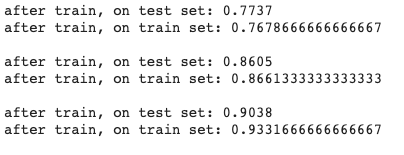

2 layers 1000 000 max_episodes

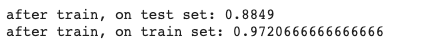

2 layers 500 000 max_episodes

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=500000, learing_rate=0.1))

Sigmoid

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = sigmoid))

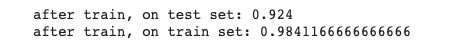

Tanh

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = tanh))

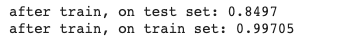

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, lamdba=0.5 ))

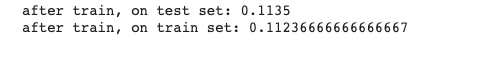

### Run on unormalized data

In [ ]:
# unormalized data
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train = x_train.reshape(num_train, -1)    # vectorization
x_test = x_test.reshape(num_test, -1)

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1))

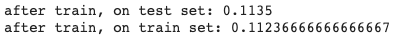

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = sigmoid))

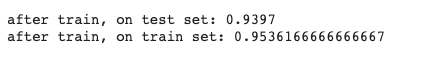

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = tanh))

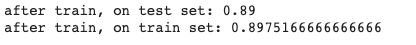

## Creativity

Investigate different width of MLP




In [ ]:
for n in [64, 128, 256, 512, 1024, 2048]:
  print("If single layer has", n, "units, then:")
  test(MLP(hidden_layer=[n], max_episode=10000, learing_rate=0.01))

  Investigate different numbers of layers in MLP

In [ ]:
for n in [64, 128, 256, 512, 1024, 2048]:
  print("If double layers has", n, "units, then:")
  test(MLP(hidden_layer=[n,n], max_episode=10000, learing_rate=0.01))

Convolutional Neural Networks (CNN)

LeNet-5 with keras 

In [ ]:
# import library
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml

# Load dataset
dataset = fetch_openml("mnist_784")

# Reshape the data to a (70000, 28, 28) tensor
data = dataset.data.reshape((dataset.data.shape[0], 28, 28))

# Reshape the data to a (70000, 28, 28, 1) tensord
data = data[:, :, :, np.newaxis]

# Scale values from range of [0-255] to [0-1]
scaled_data = data / 255.0

# Split the dataset into training and test sets
(train_data, test_data, train_labels, test_labels) = train_test_split(
    scaled_data,
    dataset.target.astype("int"), 
    test_size = 0.33)

# Tranform training labels to one-hot encoding
train_labels = np_utils.to_categorical(train_labels, 10)

# Tranform test labels to one-hot encoding
test_labels = np_utils.to_categorical(test_labels, 10)

# Create a sequential model
model = Sequential()

# Add the first convolution layer
model.add(Convolution2D(filters = 20, kernel_size = (5, 5), padding = "same", input_shape = (28, 28, 1)))

# Add a ReLU activation function
model.add(Activation(activation = "relu"))

# Add a pooling layer
model.add(MaxPooling2D(pool_size = (2, 2), strides =  (2, 2)))

# Add the second convolution layer
model.add(Convolution2D(filters = 50, kernel_size = (5, 5), padding = "same"))

# Add a ReLU activation function
model.add(Activation(activation = "relu"))

# Add a second pooling layer
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# Flatten the network
model.add(Flatten())

# Add a fully-connected hidden layer
model.add(Dense(500))

# Add a ReLU activation function
model.add(Activation(activation = "relu"))

# Add a fully-connected output layer
model.add(Dense(10))

# Add a softmax activation function
model.add(Activation("softmax"))

# Compile the network
model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr = 0.01), metrics = ["accuracy"])

# Train the model 
model.fit(train_data, train_labels, batch_size = 128, epochs = 20, verbose = 1)

# Evaluate the model
(loss, accuracy) = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 1)

# Print the model's accuracy
print(accuracy)

Final result of Lenet:

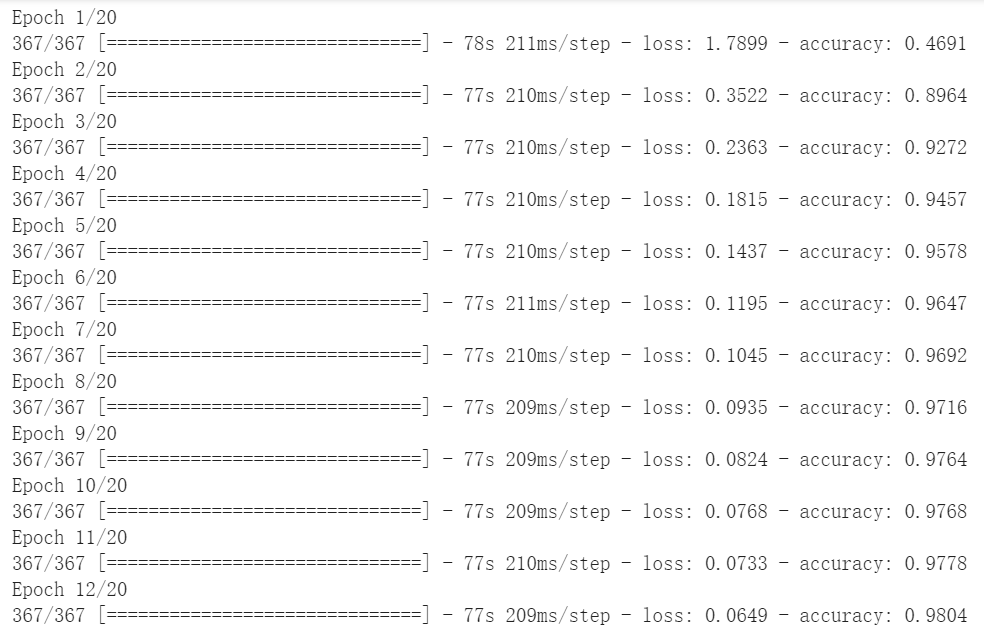


# 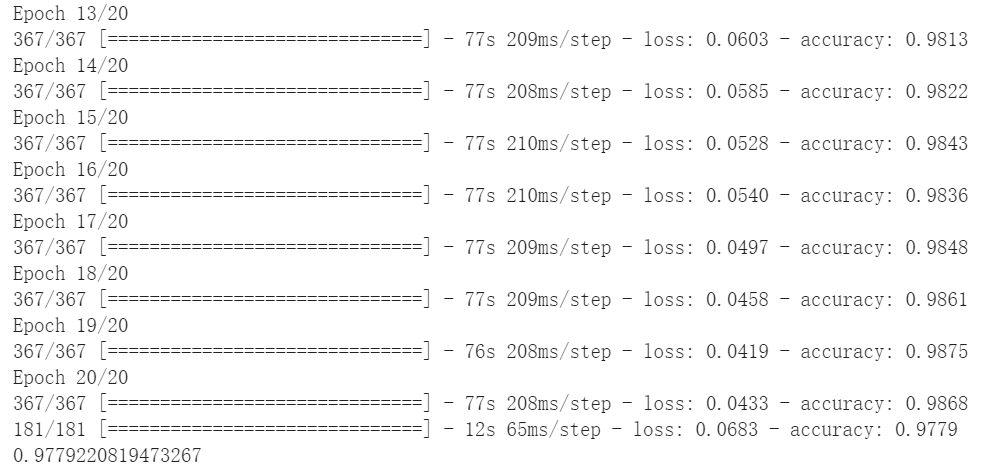